# Two layer approximation

In [44]:
import jax
import optax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

In [369]:
xrange = jnp.linspace(-3, 3, 50)[:, None]

In [738]:
def f1(x): return jnp.exp(-x ** 2 / 2) * x
def f1(x): return jnp.sin(x ** 2)

In [803]:
class MLP(nn.Module):    
    @nn.compact
    def __call__(self, x):
        hidden = nn.Dense(10)(x)
        hidden = nn.sigmoid(hidden)
        x = nn.Dense(1, name="last-layer")(hidden)
        return x, hidden

In [804]:
key  = jax.random.PRNGKey(314)
model = MLP()
pinit = model.init(key, xrange)

In [805]:
state = TrainState.create(
    apply_fn=model.apply,
    params=pinit,
    tx=optax.adam(1e-4)
)

In [806]:
def lossfn(params):
    yhat = model.apply(params, xrange)[0]
    return jnp.power(f1(xrange) - yhat, 2).mean()

def train_step(state, i):
    loss, grads = jax.value_and_grad(lossfn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [807]:
n_epochs = 500_000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(train_step, state, epochs)

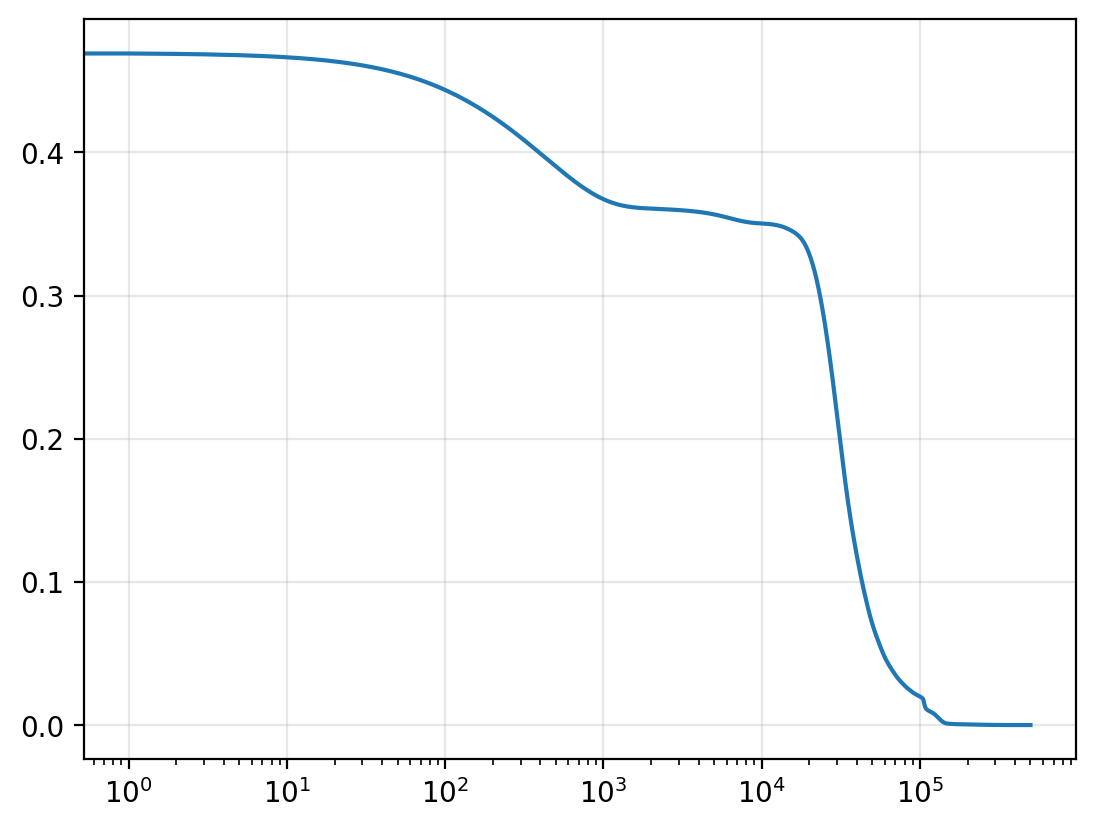

In [808]:
plt.plot(losses)
# plt.yscale("log")
plt.xscale("log")
plt.grid(alpha=0.3)

In [809]:
weights = state_final.params["params"]["last-layer"]["kernel"].ravel()
colors = (weights - weights.min()) / (weights.max() - weights.min())
colors = plt.cm.viridis(colors)

In [810]:
weights

Array([  8.566394 , -12.439012 ,  -5.964963 ,   2.921837 , -13.635897 ,
       -11.294956 ,  19.114588 ,   4.6305866,   6.849431 ,  -9.432439 ],      dtype=float32)

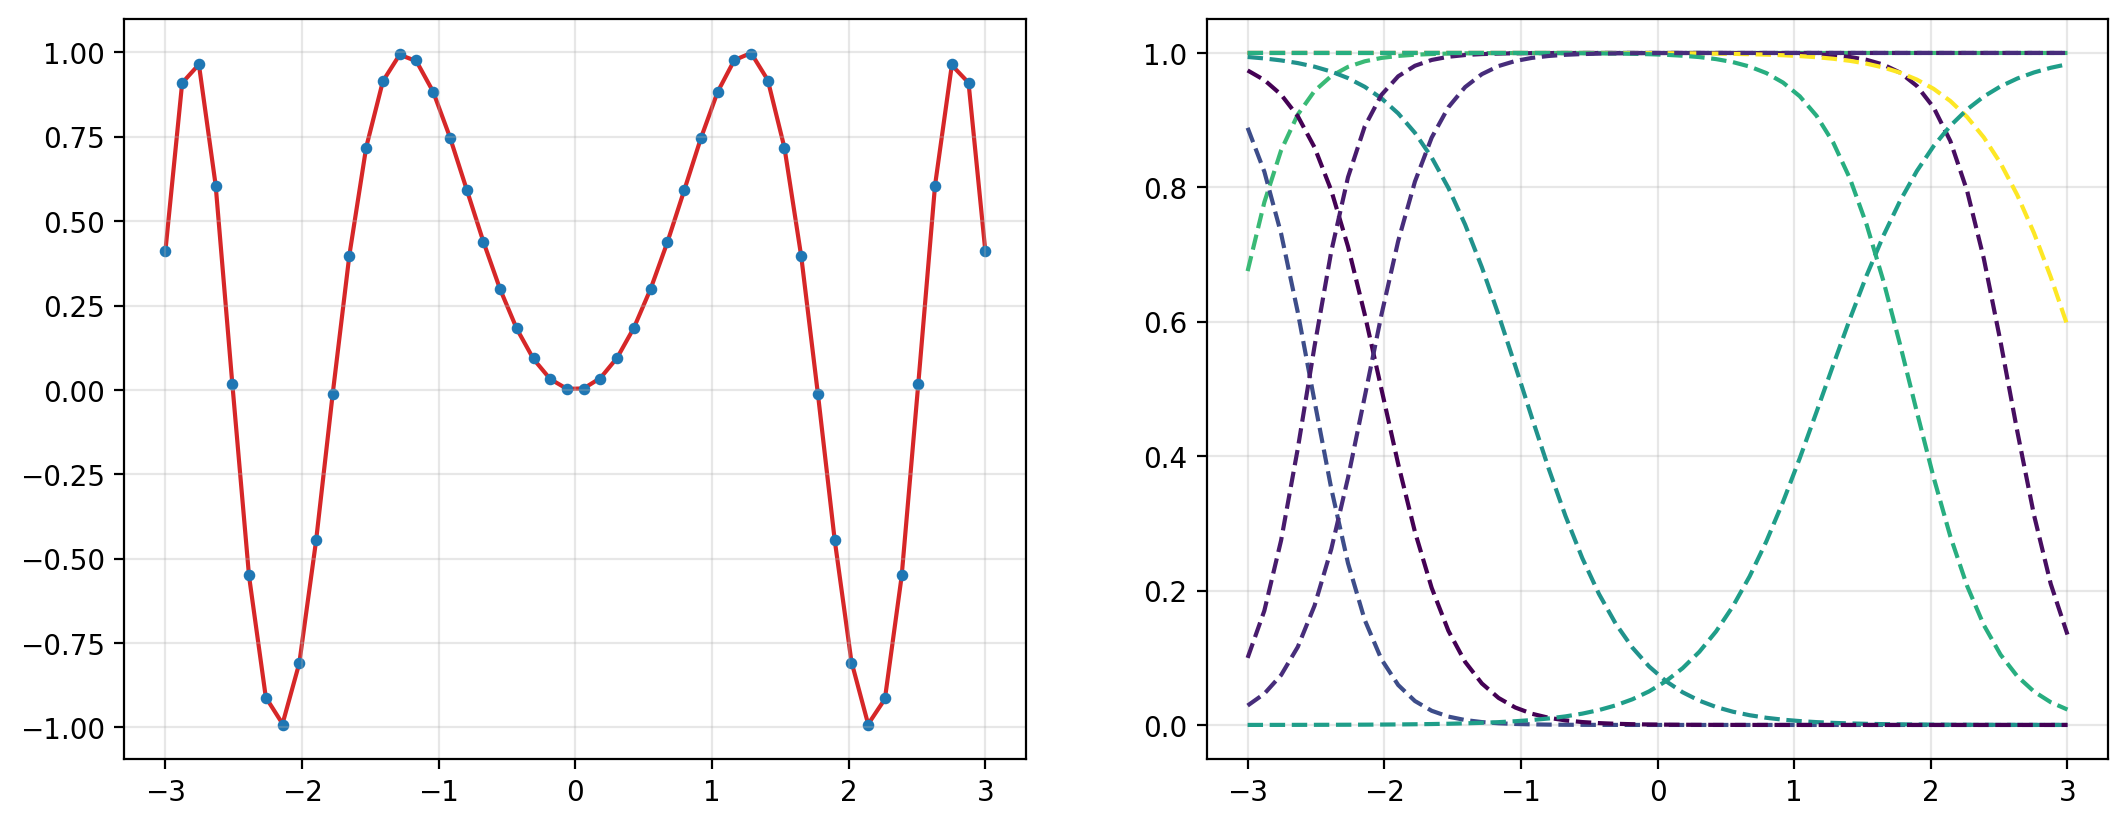

In [811]:
yhat, hidden = model.apply(state_final.params, xrange)

fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))

ax[0].plot(xrange, yhat, c="tab:red", zorder=0)
ax[0].scatter(xrange, f1(xrange), s=10)
ax[0].grid(alpha=0.3)

for c, hid in zip(colors, hidden.T):
    ax[1].plot(xrange, hid, linestyle="--", c=c)
ax[1].grid(alpha=0.3)